In this notebook, we'll build a simple [CTC](https://www.cs.toronto.edu/~graves/icml_2006.pdf) based handwriting recognition model using [GTN](https://github.com/facebookresearch/gtn) using the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database).



## Step 1: Setting up the environment


First, we will install gtn and import all the required modules. 

In [ ]:
!pip install gtn
import gtn 
import os 
import numpy
import shutil
import json 
import random 
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import display, HTML  
from PIL import Image
import numpy as np 

     |████████████████████████████████| 51kB 5.1MB/s 
  Created wheel for gtn: filename=gtn-0.0.0-cp36-cp36m-linux_x86_64.whl size=554006 sha256=4538cb569044390e56eceadd58ed58d2f6d6eba047091974031495828af23f27
  Stored in directory: /root/.cache/pip/wheels/52/4e/42/1cab375512e74e8fd09da8a78800f250376941bfc63c6b4525
Successfully built gtn


Download [gtn_applications](https://github.com/facebookresearch/gtn_applications) github repo which contains scripts to download the dataset and train/evaluate models using PyTorch. 

In [ ]:
if not os.path.exists("gtn_applications"):
  !git clone https://github.com/facebookresearch/gtn_applications.git
  assert os.path.exists("gtn_applications") and os.path.isdir("gtn_applications")
else:
  print("Looks like github repo dir `gtn_applications` exists already. Delete the dir if you want to clone again !")

Cloning into 'gtn_applications'...
remote: Enumerating objects: 1027, done.
remote: Counting objects: 100% (1027/1027), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 1027 (delta 690), reused 991 (delta 667), pack-reused 0
Receiving objects: 100% (1027/1027), 432.48 KiB | 9.40 MiB/s, done.
Resolving deltas: 100% (690/690), done.


## Step 2: Downloading the dataset

Before you start the download, register here - https://fki.tic.heia-fr.ch/login and update the email and password fields in the next section  appropriately. This will take about 5 minutes.

In [ ]:
username="<REPLACE_ME>"
password="<REPLACE_ME>"

if not os.path.exists("data"):
  os.mkdir("data")
  !datasets/download/iamdb.sh data "$username" "$password"
else:
  print("Looks like dataset dir `data` exists already. Delete the dir to download again !")

assert os.path.exists("data/sentences.txt"), "Data is not downloaded correctly. Please verify username and password."

\nLogging in and creating a session ...
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en-gb" lang="en-gb">
  <head>
    <meta http-equiv="Content-Type" content="text/html;charset=utf-8" />
    <link rel="stylesheet" type="text/css" href="/static/css/style.css" />
    <title>Research Group on Computer Vision and Artificial Intelligence &mdash; Computer Vision and Artificial Intelligence</title>
    <link rel="author"
          href="http://fki.tic.heia-fr.ch/author/admin"
          title="Author information" />
    <link rel="shortcut icon" type="image/x-icon"
          href="/static/img/favicon.ico" />
  </head>

  <body class="section-fki-1 template-document_view" dir="ltr">
    <div id="visual-portal-wrapper">
      <div id="portal-top">
        <div id="portal-header">
    <div id="unibe-logo" style="height: 130px;">
        <a href="http://www.unibe.ch/">

IAM Handwriting Database consists of handwritten English text. Let's take a look at few examples from trainset.

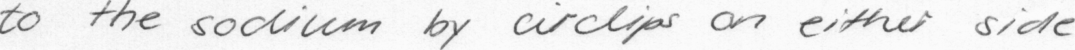

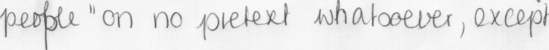

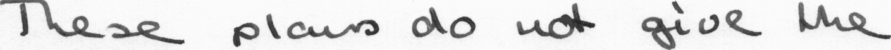

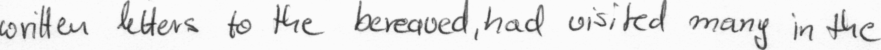

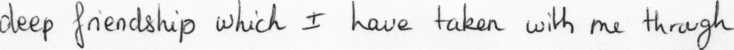

In [6]:
num_examples = 5
style = "padding: 5px ; font-family:verdana; font-size:14px; color: darkslategray; letter-spacing: 3px;"
with open("data/sentences.txt") as f:
  lines = f.readlines()
for _ in range(num_examples):
  sample = random.choice(lines)
  cols = sample.split()
  if cols[2] == "err":
    continue 
  img_file = "-".join(cols[0].split("-", 2)[:2])
  img = Image.open(f"data/{img_file}.png")
  box = tuple(int(val) for val in cols[5 : 9])
  x, y, w, h = box
  height = 50
  size = (height, int((height / h) * w))
  cropped_img = transforms.functional.resized_crop(img, y, x, h, w, size)
  display(cropped_img)
  display(HTML("<p style='{}'>{}</p><br/><br/>".format(style, cols[9:][0])))
  

## Step 3: Training the model


In [ ]:
# change current working directory 
os.chdir("gtn_applications")

In [ ]:
# creating a checkpoint dir 
if not os.path.exists("checkpoint"):
  os.mkdir("checkpoint")

Creating a traininig config. For the neural network part, we will use `TDS2D` which is a 2D variant of [Time-Depth Separable (TDS)](https://arxiv.org/abs/1904.02619) convolution block.

In [ ]:
config = {
  "seed" : 0,
  "data" : {
    "dataset" : "iamdb",
    "data_path" : "../data",
    "num_features" : 64
  },
  "model_type" : "tds2d",
  "model" : {
    "depth" : 4,
    "tds_groups" : [
      { "channels" : 4, "num_blocks" : 3, "stride" : [2, 2] },
      { "channels" : 16, "num_blocks" : 3, "stride" : [2, 2] },
      { "channels" : 32, "num_blocks" : 3, "stride" : [2, 1] },
      { "channels" : 64, "num_blocks" : 3, "stride" : [2, 1] }
    ],
    "kernel_size" : [5, 7],
    "dropout" : 0.1
  },
  "optim" : {
    "batch_size" : 32,
    "epochs" : 50, 
    "learning_rate" : 1e-1,
    "step_size" : 50,
    "max_grad_norm" : 5
  }
}

with open("checkpoint/config.json", "w") as f:
  f.write(json.dumps(config))


Start training. You can also stop training early (let's say after 10 epochs) if you want to proceed quickly to the testing stage and are not concerned about the performance.



In [ ]:
%run -i train.py --config checkpoint/config.json --checkpoint_path checkpoint 

INFO:root:World size is : 1
INFO:root:Restoring model from epoch 0
INFO:root:Using the config 
{"seed": 0, "data": {"dataset": "iamdb", "data_path": "../data", "num_features": 64}, "model_type": "tds2d", "model": {"depth": 4, "tds_groups": [{"channels": 4, "num_blocks": 3, "stride": [2, 2]}, {"channels": 16, "num_blocks": 3, "stride": [2, 2]}, {"channels": 32, "num_blocks": 3, "stride": [2, 1]}, {"channels": 64, "num_blocks": 3, "stride": [2, 1]}], "kernel_size": [5, 7], "dropout": 0.1}, "optim": {"batch_size": 32, "epochs": 50, "learning_rate": 0.1, "step_size": 50, "max_grad_norm": 5}}
INFO:root:Loading dataset ...
INFO:root:Loading model ...
INFO:root:Training tds2d model with 2,644,859 parameters.
INFO:root:Starting training ...
INFO:root:Epoch 1 started. 
INFO:root:Epoch 1 complete. nUpdates 193, Loss 4.542, CER 94.548, WER 100.572, Time 286.216 (s), LR 0.100
INFO:root:Evaluating validation set..
INFO:root:Validation Set: Loss 3.499, CER 86.348, WER 99.911, Best Loss 3.499, Best C

## Step 4: Evaluation

Evaluating on test set 




In [ ]:
%run -i test.py --config checkpoint/config.json --checkpoint_path checkpoint --split test

Streaming output truncated to the last 5000 lines.
WER: 42.857
HYP: tuned▁the▁tning▁hnob▁through▁all▁the
REF turned▁the▁tuning▁knob▁through▁all▁the
CER: 22.727
WER: 61.538
HYP: Htllo▁Dad▁!"▁Sil▁called▁.▁"▁I▁hape▁yoe
REF "▁Hello▁,▁Dad▁!▁"▁Bill▁called▁.▁"▁I▁hope▁you
CER: 21.053
WER: 54.545
HYP: Given▁her▁.▁I'msorry▁,▁darly▁.▁'
REF given▁her▁.▁'▁I▁'m▁sorry▁,▁darling▁.▁'
CER: 20.000
WER: 66.667
HYP: altle▁to▁rendo▁an▁accaunt▁of▁thir▁fah▁acordig
REF able▁to▁render▁an▁account▁of▁their▁faith▁according
CER: 20.408
WER: 80.000
HYP: eveuing-▁and▁Isuall▁look▁fomard▁ts▁mtting▁yeu
REF evening▁-▁and▁I▁shall▁look▁forward▁to▁meeting▁you
CER: 14.634
WER: 57.143
HYP: poduction▁by▁Michal▁Kayes▁.▁He▁coptieed
REF production▁by▁Michael▁Hayes▁.▁He▁captured
CER: 15.000
WER: 50.000
HYP: word▁'▁StnUIR▁"▁means▁guorded▁or▁preser
REF word▁"▁SHAMIR▁"▁means▁guarded▁or▁preser-
CER: 26.471
WER: 85.714
HYP: fake▁yon▁raind▁to▁the▁pubos▁where▁mest
REF take▁you▁round▁the▁pubs▁where▁most
CER: 22.222
WER: 42.857
HYP: hion▁a

The trained model achieves a CER of 17.0 !

To get better results, try increasing the model size and train the model for more epochs till convergence. Also, using multi GPU training (`--world_size <ngpus>`) would make the training faster. 
